In [1]:
import json
import spikeforest as sf
import spikeinterface as si
import numpy as np
import matplotlib.pyplot as plt

/home/aikusrv04/anaconda3/envs/neuron/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


# Call Data

In [2]:
synth_monotrode_uri = 'sha1://3b265eced5640c146d24a3d39719409cceccc45b?synth-monotrode-spikeforest-recordings.json'


In [3]:
all_recordings = sf.load_spikeforest_recordings(synth_monotrode_uri)

In [4]:
# list all data in synth_monotrode
i=0
for R in all_recordings:
    
    print(f'============================={i}번째============================')
    print(f'{R.study_set_name}/{R.study_name}/{R.recording_name}')
    print(f'Num. channels: {R.num_channels}')
    print(f'Duration (sec): {R.duration_sec}')
    print(f'Sampling frequency (Hz): {R.sampling_frequency}')
    print(f'Num. true units: {R.num_true_units}')
    print(f'Sorting true object: {json.dumps(R.sorting_true_object)}')
    print('')
    i+=1

=============================0번째============================
SYNTH_MONOTRODE/neurocube_quiroga_easy2/C_Easy2_noise005
Num. channels: 1
Duration (sec): 60.0
Sampling frequency (Hz): 24000.0
Num. true units: 3
Sorting true object: {"firings": "sha1://cabd4129b38bb6c1ffc1a8c2884b77b982699fca?label=firings_true.mda", "samplerate": 24000.0}

=============================1번째============================
SYNTH_MONOTRODE/neurocube_quiroga_easy2/C_Easy2_noise01
Num. channels: 1
Duration (sec): 60.0
Sampling frequency (Hz): 24000.0
Num. true units: 3
Sorting true object: {"firings": "sha1://1d1d983101acd215176196e6cd6eb2764a611209?label=firings_true.mda", "samplerate": 24000.0}

=============================2번째============================
SYNTH_MONOTRODE/neurocube_quiroga_easy2/C_Easy2_noise015
Num. channels: 1
Duration (sec): 60.0
Sampling frequency (Hz): 24000.0
Num. true units: 3
Sorting true object: {"firings": "sha1://f2f788f39bf6d5151889284ec87de00e63de218b?label=firings_true.mda", "sampler

In [ ]:
def make_gt_data(all_recordings):
    sorting = all_recordings.get_sorting_true_extractor()
    unit_ids = sorting.get_unit_ids()

    
    all_spikes = []
    for unit_id in unit_ids:
        spike_times = sorting.get_unit_spike_train(unit_id=unit_id)
        for t in spike_times:
            all_spikes.append((t, unit_id))

    
    all_spikes_sorted = sorted(all_spikes, key=lambda x: x[0])

    
    spike_frame_sorted = np.array([s[0] for s in all_spikes_sorted])
    # print(spike_times_sorted.shape)
    # print(type(spike_times_sorted))
    # print(spike_times_sorted[:10])
    # print('-----------------------------------')

    spike_labels_sorted = np.array([s[1] for s in all_spikes_sorted])
    # print(spike_labels_sorted.shape)
    # print(type(spike_labels_sorted))
    # print(spike_labels_sorted[:10])
    return spike_frame_sorted , spike_labels_sorted

In [6]:
def recording_get_traces(recording):
    data = recording.get_recording_extractor()
    raw_data = data.get_traces()
    return raw_data


In [ ]:
all_data = []
n=50
for i,R in enumerate(all_recordings):
    if i >= n:
        break
    entry = {
        'recording_name': R.recording_name,
        '# of channels': R.num_channels,
        'duration(sec)': R.duration_sec,
        'fs': R.sampling_frequency,
        '# of units': R.num_true_units,
        'traces': recording_get_traces(R),
    }
    entry['spike_frame_sorted'],entry['spike_labels_sorted'] = make_gt_data(R)
    all_data.append(entry)
    
print(len(all_data))
print(all_data[0].keys())
print(len(all_data[0]['traces']))
print(all_data[0]['spike_frame_sorted'][:10])
print()

50
dict_keys(['recording_name', '# of channels', 'duration(sec)', 'fs', '# of units', 'traces', 'spike_frame_sorted', 'spike_labels_sorted'])
1440000
[ 381  834 1040 1384 1537 1554 1748 2293 2798 3272]



# Data Preprocessing

In [8]:
from scipy.signal import butter, filtfilt

def bandstop_filter(signal, fs, lowcut=300, highcut=6000, order=3):
    nyq = 0.5 * fs
    low = lowcut / nyq
    high = highcut / nyq
    b, a = butter(order, [low, high], btype='bandstop')
    return filtfilt(b, a, signal, axis=0)

In [9]:
import spikeinterface.extractors as se
import spikeinterface.preprocessing as pre
def band_filtering(traces,fs):

    recording = se.NumpyRecording(
        traces_list = traces,
        sampling_frequency=fs
        )
    bandpass_filtered = pre.bandpass_filter(
                        recording, freq_min=300, freq_max=6000, dtype="float32"
                    )
    bandstop_filtered = se.NumpyRecording(
                        traces_list=bandstop_filter(signal=traces,fs=fs),
                        sampling_frequency=fs
        )
    return bandpass_filtered.get_traces(), bandstop_filtered.get_traces()



In [10]:
for i in range(len(all_data)):
    all_data[i]['traces_bandpassed'], all_data[i]['traces_bandstopped'] = band_filtering(all_data[i]['traces'],all_data[i]['fs'])

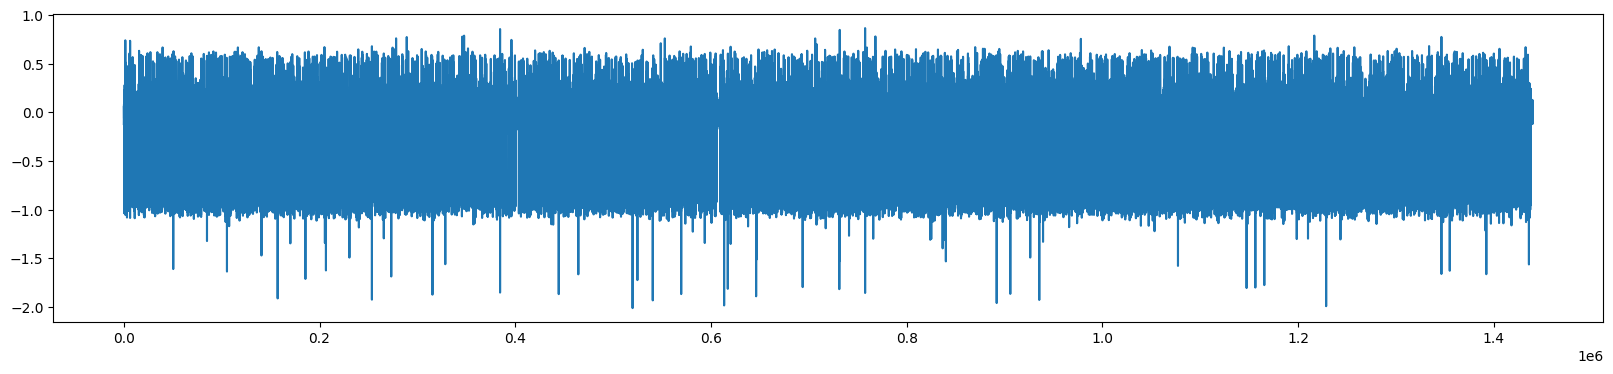

In [11]:
plt.figure(figsize=(20,4))
plt.plot(all_data[0]['traces'])

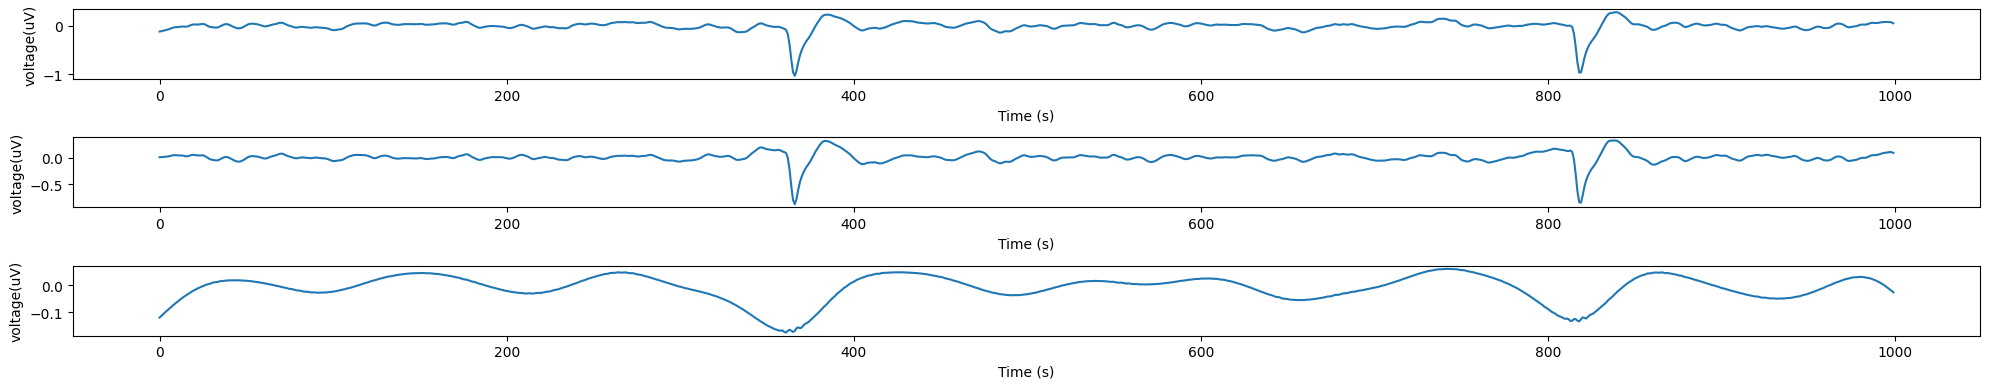

In [12]:
# plotting filtered data
fig,axes = plt.subplots(3,1,figsize = (20,4))


axes[0].plot(all_data[0]['traces'][:1000])
axes[0].set_ylabel('voltage(uV)')
axes[0].set_xlabel('Time (s)')

axes[1].plot(all_data[0]['traces_bandpassed'][:1000])
axes[1].set_ylabel('voltage(uV)')
axes[1].set_xlabel('Time (s)')

axes[2].plot(all_data[0]['traces_bandstopped'][:1000])
axes[2].set_ylabel('voltage(uV)')
axes[2].set_xlabel('Time (s)')

plt.tight_layout()

In [13]:
import torch
import os

torch.cuda.set_device(4)
os.environ["CUDA_VISIBLE_DEVICES"] = "4" 
print(os.environ.get("CUDA_VISIBLE_DEVICES"))

4


# Making waveform with GT

In [ ]:
def compute_waveform(
    traces: np.ndarray,
    gt_frame_list: np.ndarray,            
    ms_before: float = 0.5,
    ms_after: float = 1.0,
    sampling_freq: int = 24000,
    search_radius: int = 15          
    
):
    traces = np.asarray(traces)
    if traces.ndim == 1:
        traces = traces[:, None]
    n_samples, n_channels = traces.shape


    

    frame_before = int(sampling_freq * ms_before / 1000.0)
    frame_after  = int(sampling_freq * ms_after  / 1000.0)
    window_size  = frame_before + frame_after


    n_spikes = len(gt_frame_list)
    waveforms = np.zeros((n_spikes, window_size, n_channels), dtype=traces.dtype)
    refined_frames = np.empty(n_spikes, dtype=int)


    def safe_slice(a, start, end):
        
        left_pad = 0
        right_pad = 0
        valid_start = start
        valid_end = end

        if start < 0:
            left_pad = -start
            valid_start = 0
        if end > n_samples:
            right_pad = end - n_samples
            valid_end = n_samples
        return left_pad, right_pad, valid_start, valid_end

    
    for i, est_frame in enumerate(gt_frame_list):
        
        sr_left  = max(0, est_frame - search_radius)
        sr_right = min(n_samples, est_frame + search_radius + 1)  

       
        
        offset = int(np.argmin(traces[sr_left:sr_right]))

        peak_frame = sr_left + offset
        refined_frames[i] = peak_frame


        start = peak_frame - frame_before
        end   = peak_frame + frame_after


        left_pad, right_pad, valid_start, valid_end = safe_slice(traces, start, end)
        for ch in range(n_channels):
            if left_pad > 0:
                waveforms[i, :left_pad, ch] = traces[0, ch]
            if right_pad > 0:
                waveforms[i, window_size - right_pad:, ch] = traces[-1, ch]
            waveforms[i, left_pad:window_size - right_pad, ch] = traces[valid_start:valid_end, ch]

    return waveforms.squeeze(), refined_frames


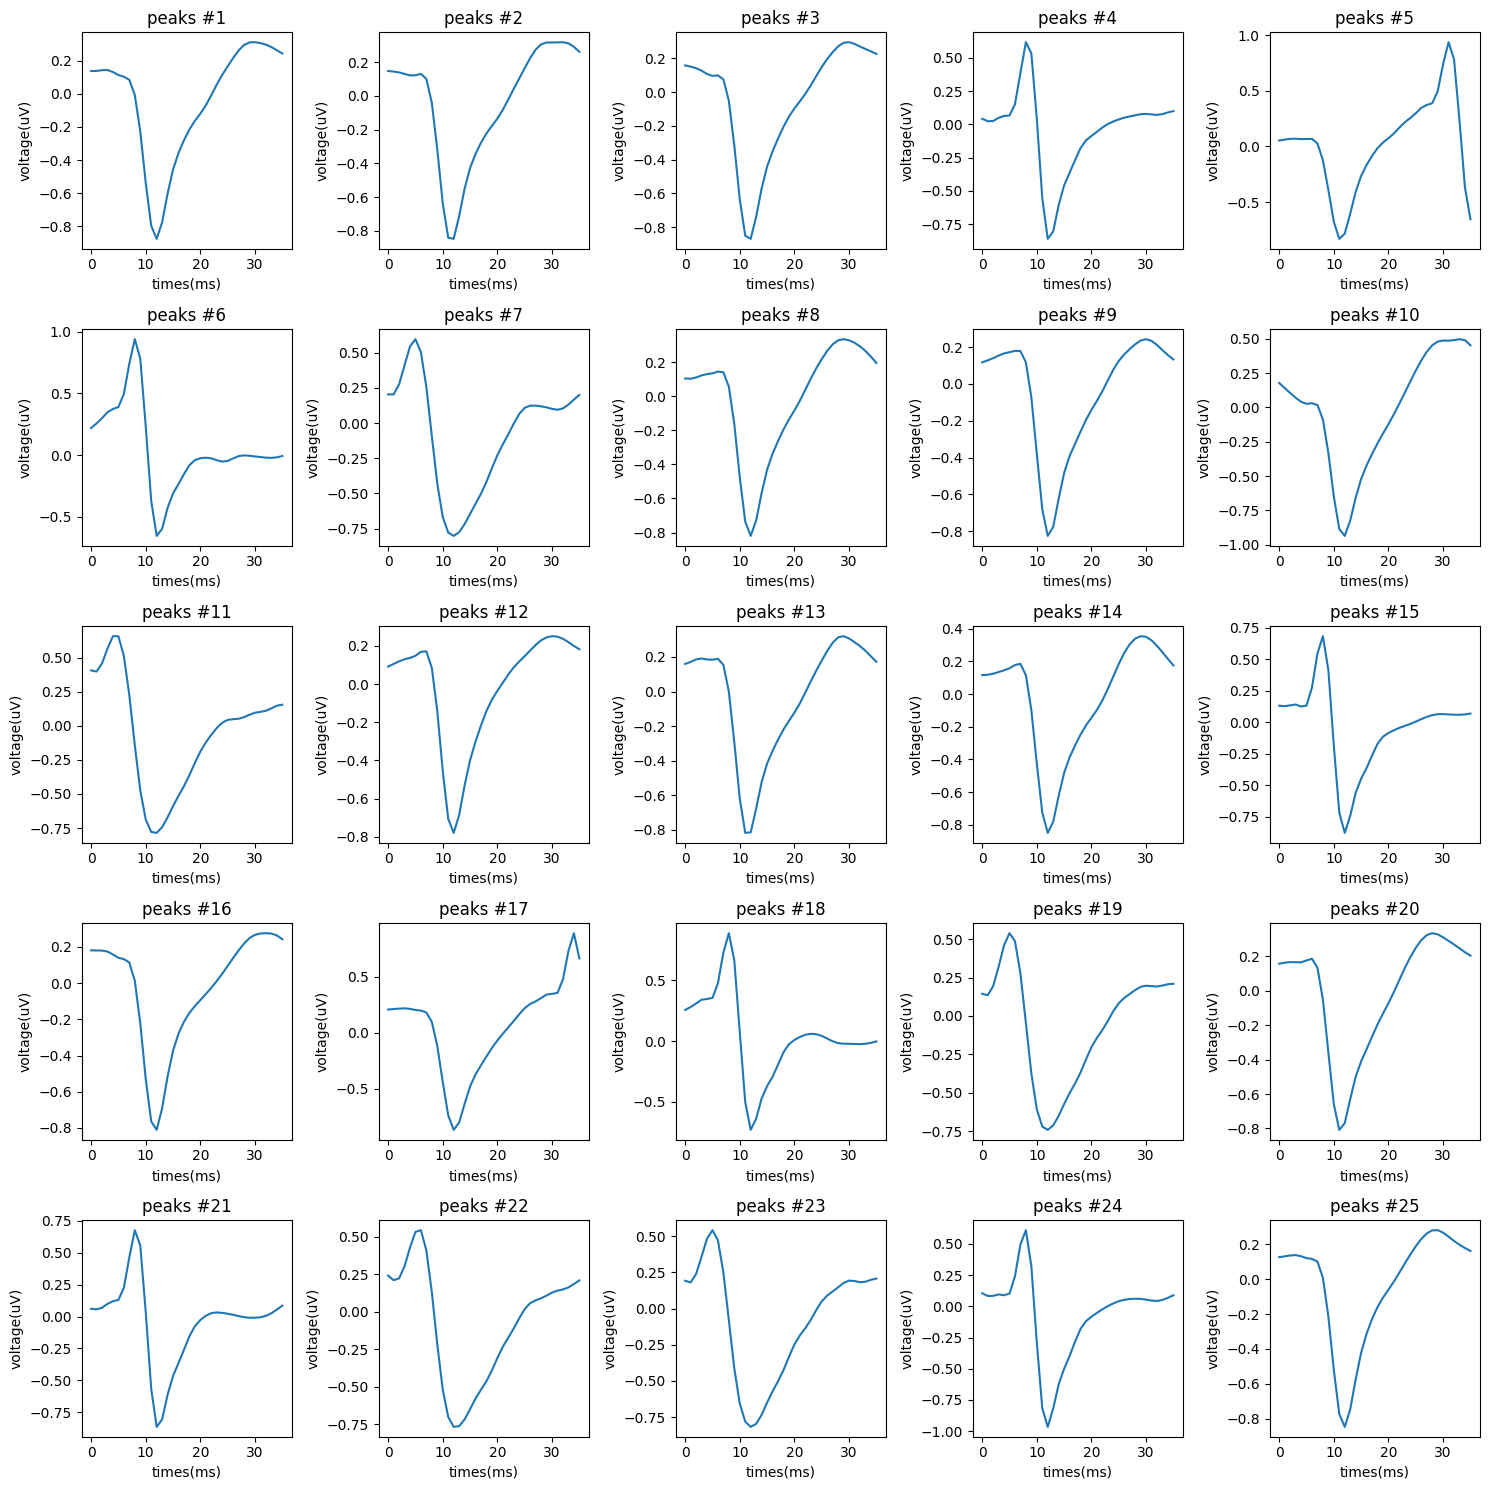

In [15]:

for i in range(len(all_data)):
    all_data[i]['waveforms_GT'],all_data[i]['real_GT_frame_list'] = compute_waveform(traces=all_data[i]['traces_bandpassed'],gt_frame_list=all_data[i]['spike_frame_sorted'])
    

fig,axes = plt.subplots(5,5,figsize = (15,15))
axes = axes.flatten()

for i in range(25):
    axes[i].plot(all_data[0]['waveforms_GT'][i,:])
    axes[i].set_xlabel('times(ms)')
    axes[i].set_ylabel('voltage(uV)')
    axes[i].set_title(f'peaks #{i+1}')
plt.tight_layout()



In [ ]:
import random as rd
def pick_random_nonspike_centers(trace,len_trace, spike_frames, num_of_noise,
                                 nbefore=12, nafter=24,  
                                 seed=None):
    if seed is not None:
        rd.seed(seed)
        np.random.seed(seed)

    spike_frames = np.asarray(spike_frames, dtype=int)
    

    
    mask = np.ones(len_trace, dtype=bool)

    
    for p in spike_frames:
        s = max(0, p - nbefore)
        e = min(len_trace, p + nafter + 1)  
        mask[s:e] = False
        
    mask[:nbefore] = False
    mask[len_trace - nafter:] = False

    
    candidates = np.flatnonzero(mask)
    if len(candidates) == 0:
        raise ValueError("조건을 만족하는 후보 인덱스가 없습니다. exclude/window/데이터 길이를 확인하세요.")

    
    k_eff = min(num_of_noise, len(candidates))
    centers = np.array(rd.sample(list(candidates), k_eff), dtype=int)

    
    
    noise_waveforms = np.zeros((num_of_noise,nbefore+nafter),dtype=trace.dtype)
    for i,center in enumerate(centers):
        noise_waveforms[i, :] = trace[center-nbefore:center+nafter].reshape(-1)
    return centers, noise_waveforms




In [17]:

for i in range(len(all_data)):
    len_trace = len(all_data[i]['traces'])
    all_data[i]['noise_frame_list'], all_data[i]['waveforms_noise'] =pick_random_nonspike_centers(trace= all_data[i]['traces_bandpassed'],len_trace=len_trace,spike_frames=all_data[i]['real_GT_frame_list'],num_of_noise=len(all_data[i]['real_GT_frame_list']))

In [18]:
print(all_data[0]['waveforms_noise'].shape)
print(all_data[0]['waveforms_GT'].shape)

(3410, 36)
(3410, 36)


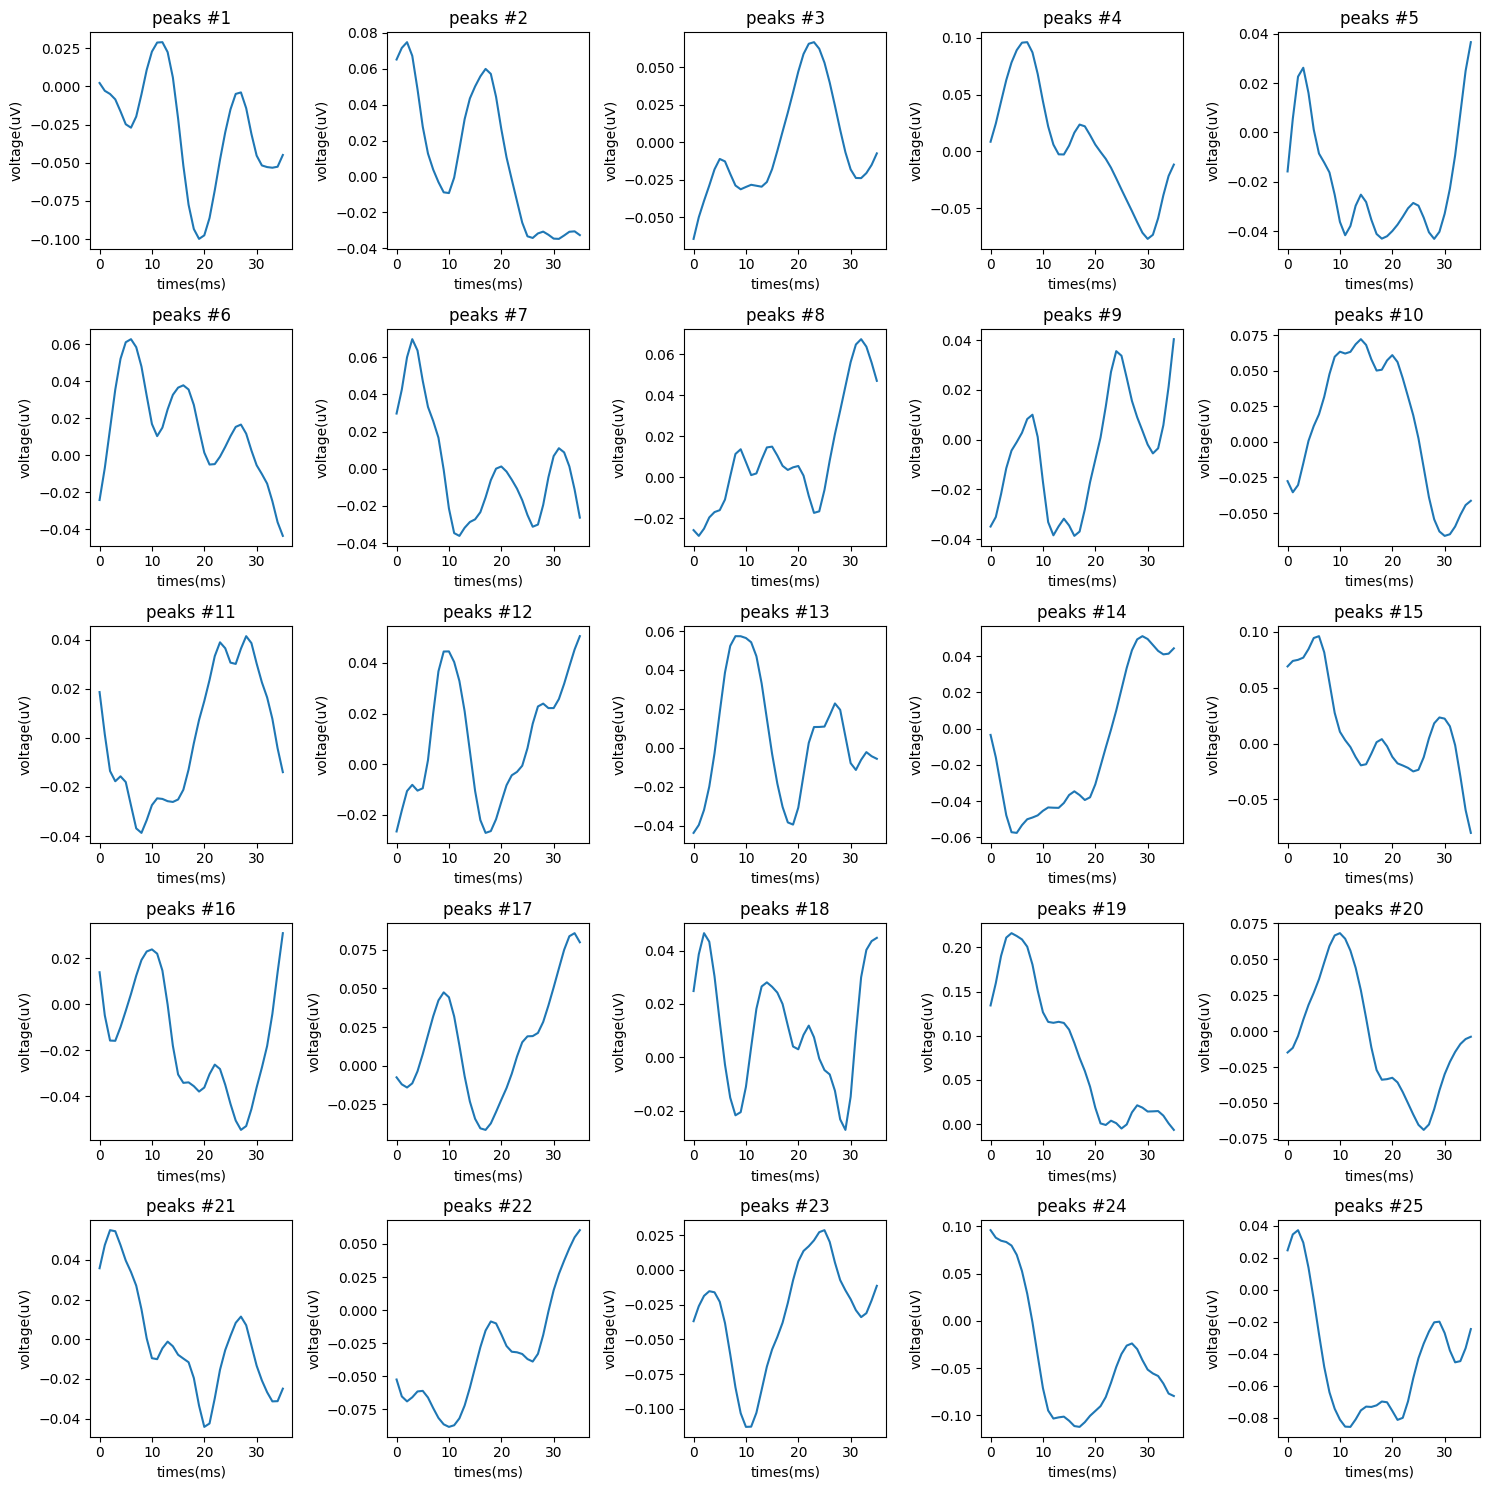

In [19]:


fig,axes = plt.subplots(5,5,figsize = (15,15))
axes = axes.flatten()

for i in range(25):
    axes[i].plot(all_data[0]['waveforms_noise'][i,:])
    axes[i].set_xlabel('times(ms)')
    axes[i].set_ylabel('voltage(uV)')
    axes[i].set_title(f'peaks #{i+1}')
plt.tight_layout()



In [20]:
import pywt

def compute_wavelet(waveforms, wavelet='db4', level=2):
    W = np.asarray(waveforms)
    N,T = waveforms.shape
    B = level +1
    X = np.zeros((N,B,T),dtype=np.float32)
    print()
    for i in range(N):
        coeffs = pywt.swt(W[i],wavelet=wavelet,level=level,trim_approx=False)
        cA_L, _ = coeffs[-1]
        bands = [cA_L] + [cD for (_, cD) in coeffs[::-1]]
        X[i] = np.stack(bands, axis=0)
    return X

In [21]:
for i in range(len(all_data)):
    all_data[i]['wavelet_GT'] = compute_wavelet(all_data[i]['waveforms_GT'])
    all_data[i]['wavelet_noise'] = compute_wavelet(all_data[i]['waveforms_noise'])



Text(0.5, 1.0, 'Wavelet_GT')

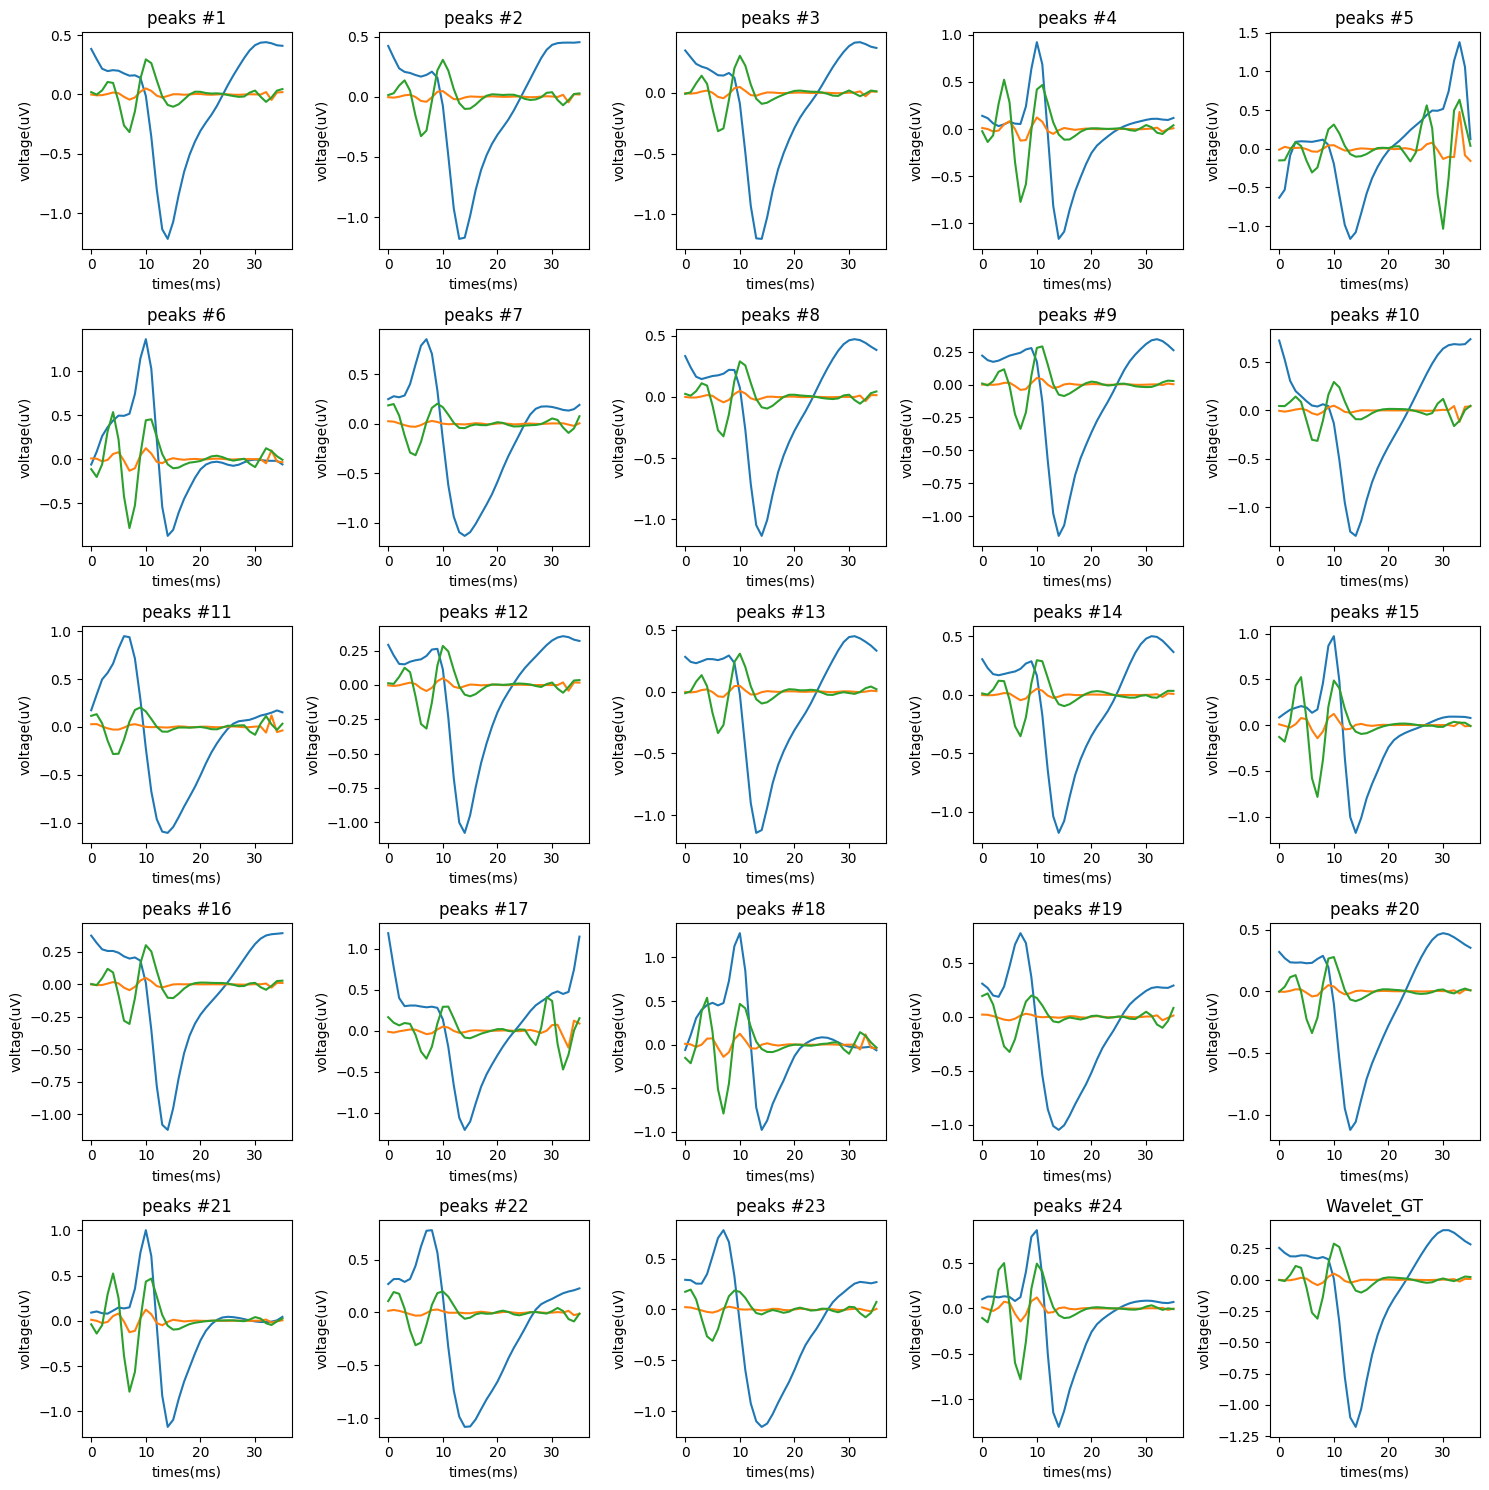

In [22]:
fig,axes = plt.subplots(5,5,figsize = (15,15))
axes = axes.flatten()

for i in range(25):
    for j in range(3):
        axes[i].plot(all_data[0]['wavelet_GT'][i,j,:])
    axes[i].set_xlabel('times(ms)')
    axes[i].set_ylabel('voltage(uV)')
    axes[i].set_title(f'peaks #{i+1}')
plt.tight_layout()
plt.title('Wavelet_GT')



(3410, 3, 36)


Text(0.5, 1.0, 'Wavelet_Noise')

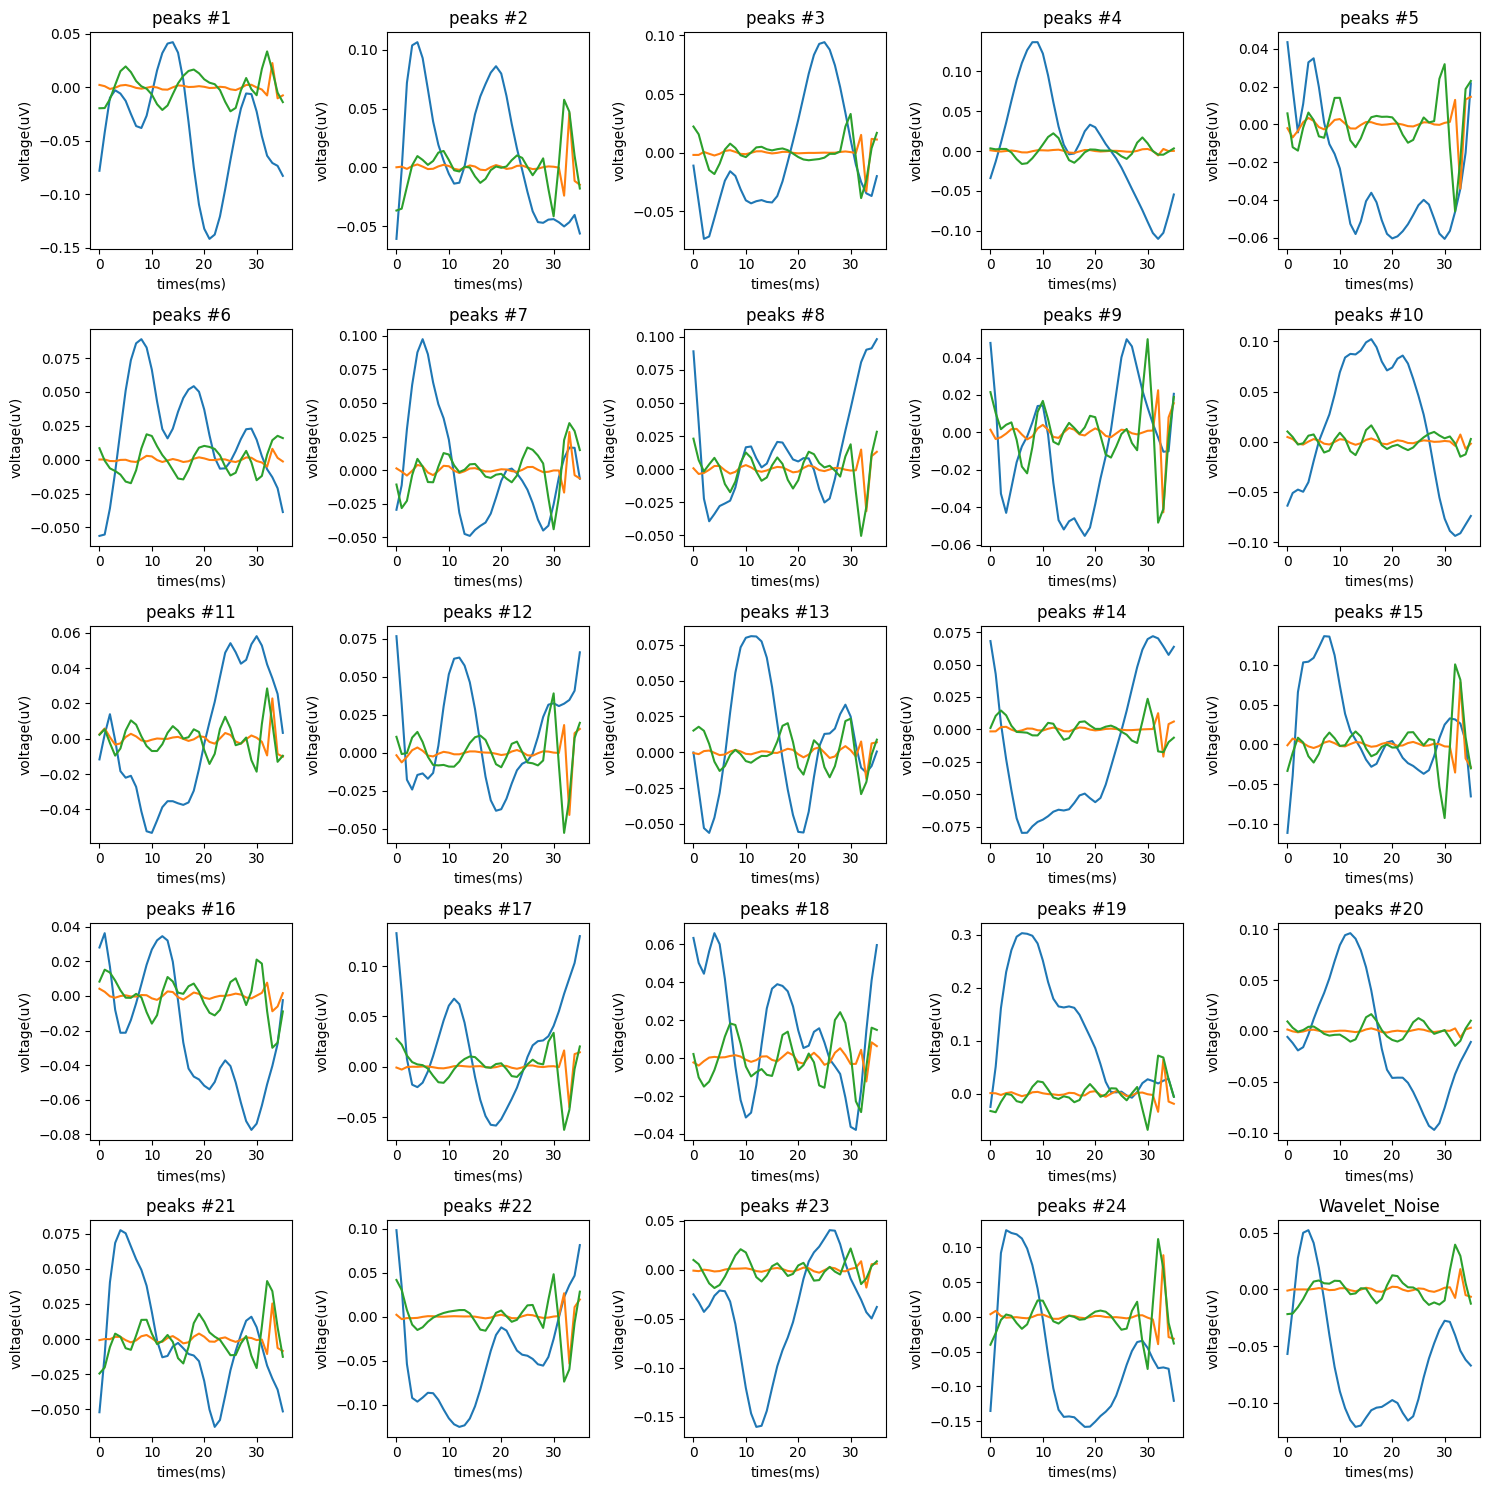

In [23]:
print(all_data[0]['wavelet_GT'].shape)


fig,axes = plt.subplots(5,5,figsize = (15,15))
axes = axes.flatten()

for i in range(25):
    for j in range(3):
        axes[i].plot(all_data[0]['wavelet_noise'][i,j,:])
    axes[i].set_xlabel('times(ms)')
    axes[i].set_ylabel('voltage(uV)')
    axes[i].set_title(f'peaks #{i+1}')
plt.tight_layout()
plt.title('Wavelet_Noise')



In [ ]:



from torch.utils.data import Dataset, DataLoader, random_split

for i in range(len(all_data)):
    all_data[i]['label_spike'] = np.ones(all_data[i]['wavelet_GT'].shape[0])
    all_data[i]['label_noise'] = np.zeros(all_data[i]['wavelet_noise'].shape[0])
    
print(all_data[0]['label_spike'].shape)


(3410,)


In [ ]:
gt_data_list = []
noise_data_list = []
gt_label_list = []
noise_label_list = []

for i in range(len(all_data)):
    gt_data_list.append(all_data[i]['wavelet_GT'])
    noise_data_list.append(all_data[i]['wavelet_noise'])
    gt_label_list.append(all_data[i]['label_spike'])
    noise_label_list.append(all_data[i]['label_noise'])


X_spikes = np.vstack(gt_data_list)
X_noise = np.vstack(noise_data_list)
y_spikes = np.concatenate(gt_label_list)
y_noise = np.concatenate(noise_label_list)


all_wavelet_data = np.vstack([X_spikes, X_noise])
all_wavelet_label = np.concatenate([y_spikes, y_noise])

print(all_wavelet_data.shape)

(564084, 3, 36)


In [ ]:
import torch
from torch.utils.data import Dataset, DataLoader, random_split

class WaveletDataset(Dataset):
    def __init__(self, features, labels):
        self.features = torch.tensor(features, dtype=torch.float32)
        self.labels = torch.tensor(labels, dtype=torch.float32).unsqueeze(1)

    def __len__(self):
        return len(self.features)

    def __getitem__(self, idx):
        return self.features[idx], self.labels[idx]

    


full_dataset = WaveletDataset(all_wavelet_data, all_wavelet_label)


train_size = int(0.8 * len(full_dataset))
test_size = len(full_dataset) - train_size
train_dataset, test_dataset = random_split(full_dataset, [train_size, test_size])

BATCH_SIZE = 64
train_loader = DataLoader(dataset=train_dataset, batch_size=BATCH_SIZE, shuffle=True)
test_loader = DataLoader(dataset=test_dataset, batch_size=BATCH_SIZE, shuffle=False)

print("\n--- DataLoader 생성 완료 ---")
print(f"훈련 데이터 로더의 배치 개수: {len(train_loader)}")
print(f"테스트 데이터 로더의 배치 개수: {len(test_loader)}")

features_batch, labels_batch = next(iter(train_loader))
print(f"하나의 훈련 배치(feature) 형태: {features_batch.shape}")
print(f"하나의 훈련 배치(label) 형태: {labels_batch.shape}")


--- DataLoader 생성 완료 ---
훈련 데이터 로더의 배치 개수: 7052
테스트 데이터 로더의 배치 개수: 1763
하나의 훈련 배치(feature) 형태: torch.Size([64, 3, 36])
하나의 훈련 배치(label) 형태: torch.Size([64, 1])


In [ ]:

import torch.nn as nn
import torch.optim as optim

class SimpleCNN(nn.Module):
    def __init__(self, input_shape=(3, 36)):
        super(SimpleCNN, self).__init__()
        C, T = input_shape

        self.conv_layers = nn.Sequential(
            nn.Conv1d(C, C, kernel_size=3, padding=1,groups=C),  # (3→16)
            nn.ReLU(),
            nn.MaxPool1d(2),  

            nn.Conv1d(C, 32, kernel_size=3, padding=1),  # (16→32)
            nn.ReLU(),
            nn.MaxPool1d(2),  
            
            nn.Conv1d(32, 64, kernel_size=3, padding=1),  # (16→32)
            nn.ReLU(),
            nn.MaxPool1d(2)
        )

        
        dummy = torch.zeros(1, C, T)
        out = self.conv_layers(dummy)
        conv_out_dim = out.numel()

        self.fc_layers = nn.Sequential(
            nn.Linear(conv_out_dim, 64),
            nn.ReLU(),
            nn.Linear(64, 1),
            nn.Sigmoid()
        )

    def forward(self, x):
        
        x = self.conv_layers(x)
        x = x.view(x.size(0), -1)  # flatten
        x = self.fc_layers(x)
        return x


model = SimpleCNN((3, 36))
print(model)


criterion = nn.BCELoss()
optimizer = optim.Adam(model.parameters(), lr=1e-3)


EPOCHS = 8
for epoch in range(EPOCHS):
    model.train()
    running_loss = 0.0
    for X, y in train_loader:
        optimizer.zero_grad()
        outputs = model(X)
        loss = criterion(outputs, y)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()

    avg_loss = running_loss / len(train_loader)


    model.eval()
    correct, total = 0, 0
    y_true = []
    y_pred = []
    with torch.no_grad():
        for X, y in test_loader:
            outputs = model(X)
            preds = (outputs > 0.5).float()
            correct += (preds == y).sum().item()
            total += y.size(0)
            y_true.extend(y.numpy().flatten())
            y_pred.extend(preds.numpy().flatten())

    acc = correct / total
    print(f"Epoch {epoch+1}/{EPOCHS}, Loss: {avg_loss:.4f}, Test Acc: {acc:.4f}")


SimpleCNN(
  (conv_layers): Sequential(
    (0): Conv1d(3, 3, kernel_size=(3,), stride=(1,), padding=(1,), groups=3)
    (1): ReLU()
    (2): MaxPool1d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv1d(3, 32, kernel_size=(3,), stride=(1,), padding=(1,))
    (4): ReLU()
    (5): MaxPool1d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Conv1d(32, 64, kernel_size=(3,), stride=(1,), padding=(1,))
    (7): ReLU()
    (8): MaxPool1d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (fc_layers): Sequential(
    (0): Linear(in_features=256, out_features=64, bias=True)
    (1): ReLU()
    (2): Linear(in_features=64, out_features=1, bias=True)
    (3): Sigmoid()
  )
)
Epoch 1/8, Loss: 0.2513, Test Acc: 0.9137
Epoch 2/8, Loss: 0.2075, Test Acc: 0.9181
Epoch 3/8, Loss: 0.1990, Test Acc: 0.9176
Epoch 4/8, Loss: 0.1949, Test Acc: 0.9197
Epoch 5/8, Loss: 0.1918, Test Acc: 0.9211
Epoch 6/8, Loss: 0.1898, Test Acc: 0.9209
Ep

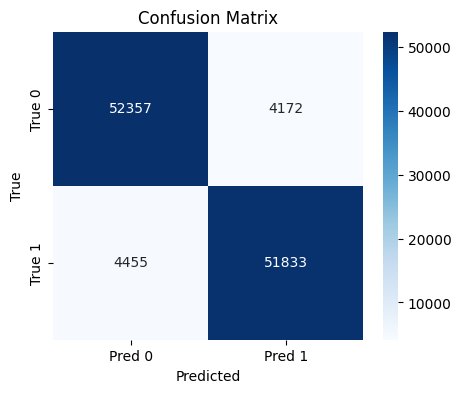

Precision:0.9255


In [40]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
cm = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(5, 4))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
            xticklabels=["Pred 0","Pred 1"],
            yticklabels=["True 0","True 1"])
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Confusion Matrix")
plt.show()

TN, FP, FN, TP = cm.ravel()

precision = TP / (TP + FP) if (TP + FP) > 0 else 0
print(f"Precision:{precision:.4f}" )